# Chamfer Approximation

In this notebook we attempt to approximate the chamfer similarity directly. First, we build an LSH forest for each document and query to find the closest matching vector before taking the dot product. Second, we use an LSH forest that encorporates multiple documents together and perform this same estimation.

Calculate Chamfer Directly:
- Extremely fast in practice
- $O(n^2qd)$. 

Simple LSH Forest
- Slowest in practice
- $O(nq(lk_m + ad + a log(a)))$

The multi-document Forest
- Slightly faster than simple approach above
- $O(nq(lk_m + ad + a log(a)))$

In [ ]:
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
sys.path.append(os.path.abspath("../src"))
from shared.lsh_forest import LSHForest, MultiDocLSHForest, RandomHyperplaneLSH
from shared.utils import chamfer, build_multidoc_lsh, build_simple_lsh, experiment, recall
from shared.plotting import plot, plot_similarity_heatmap

def simple_approximate_best(forests: list[LSHForest], queries, a):
        matches = np.empty((n, q, d), dtype=np.float32)
        for document, forest in enumerate(forests):
                for i, query in enumerate(queries):
                        idx = forest.query(query, a, dist=distance)[0][0]
                        matches[document, i] = forest.data[idx]
        sims = np.tensordot(matches, queries, axes=([1, 2], [0, 1]))
        best_doc = int(np.argmax(sims))
        return float(sims[best_doc]), best_doc

def multidoc_approximate_best(forest: MultiDocLSHForest, queries, a):
        matches = np.empty((n, q, d), dtype=np.float32)
        for i, query in enumerate(queries):
                results = forest.query(query, a, dist=distance)
                for document, result in enumerate(results):
                        idx, _ = result[0]
                        matches[document, i] = forest.data[document][idx]
        sims = np.tensordot(matches, queries, axes=([1, 2], [0, 1]))
        best_doc = int(np.argmax(sims))
        return float(sims[best_doc]), best_doc


n = 100                                 # number of documents
q = 25                                  # vectors per query
m = 64                                  # vectors per document
d = 16                                  # dimension per vector
l = 10                                  # trees per forest
k = 20                                  # pivots to keep per node in tree
km = 64                                 # max depth of each tree
a = 15                                  # number of neighbors to retrieve per query
rng = np.random.default_rng(42)
distance = lambda a, b: -np.dot(a, b)
defaults = dict(l=l, k=k, km=km, a=a)

experiments = {
        'l':  [1, 4, 8, 16, 32],
        'k':  [4, 8, 16, 32, 64],
        'km': [16, 32, 64, 128, 256],
        'a':  [1, 4, 8, 16, 32]
}


In [20]:
# Creating Simulated Data with Similarity Dropoff
# Create a base document
base_doc = rng.normal(size=(m, d)).astype(np.float32)
base_doc /= np.linalg.norm(base_doc, axis=-1, keepdims=True)

# Query = a noisy subset of the base document (with reordering and dropout)
query_indices = rng.choice(m, size=q, replace=False)
queries = base_doc[query_indices] + 0.1 * rng.normal(size=(q, d))  # small noise
queries /= np.linalg.norm(queries, axis=-1, keepdims=True)

def make_noisy_doc(base_doc, noise_scale):
    noise = rng.normal(size=base_doc.shape).astype(np.float32)
    corrupted = base_doc + noise_scale * noise
    corrupted /= np.linalg.norm(corrupted, axis=-1, keepdims=True)
    return corrupted

# Insert the base_doc as the first "perfect" match
vectors = np.empty((n, m, d), dtype=np.float32)
vectors[0] = base_doc

# Gradually increasing noise
max_noise = 0.5
for i in range(1, n):
    alpha = i / (n - 1)  # smoothly ramps from 0 to 1
    noise_scale = alpha * max_noise
    vectors[i] = make_noisy_doc(base_doc, noise_scale)

# Normalize
base_doc /= np.linalg.norm(base_doc, axis=-1, keepdims=True)
queries /= np.linalg.norm(queries, axis=-1, keepdims=True)

# Baseline
best = (0, 0)
for document, doc_vecs in enumerate(vectors):
        sim = chamfer(queries, doc_vecs)
        if sim >= best[0]:
                best = (float(sim), document)
print(queries.shape)
print(vectors.shape)
print(best)

(25, 16)
(10, 64, 16)
(23.174206377123884, 0)


In [21]:
# Constructors for each forest type
def build_simple_lsh(l, k, km):
        single_doc_forests = [LSHForest(RandomHyperplaneLSH(d), l, k, km) for _ in range(n)]
        for doc, forest in enumerate(single_doc_forests):
                forest.batch_insert(vectors[doc])
        return single_doc_forests

def build_multidoc_lsh(l, k, km):
        multi_doc_forest = MultiDocLSHForest(RandomHyperplaneLSH(d), l, k, km)
        multi_doc_forest.batch_insert(vectors)
        return multi_doc_forest

l=1 completed in 0.2708 seconds.
l=4 completed in 0.7955 seconds.
l=8 completed in 1.4914 seconds.
l=16 completed in 2.6312 seconds.
l=32 completed in 5.1682 seconds.

Finished experiment with varying l in 10.3584 seconds.


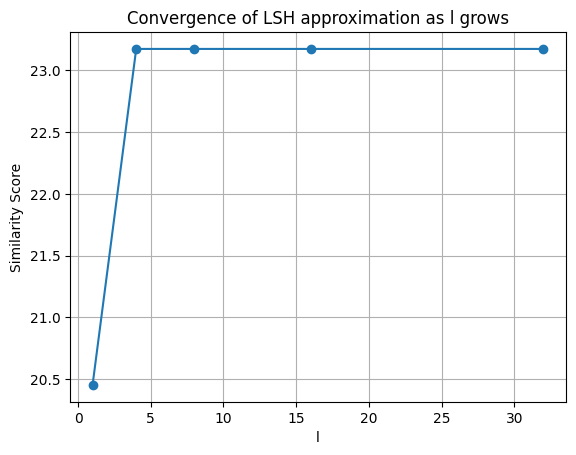

Best l = 4 → doc #0


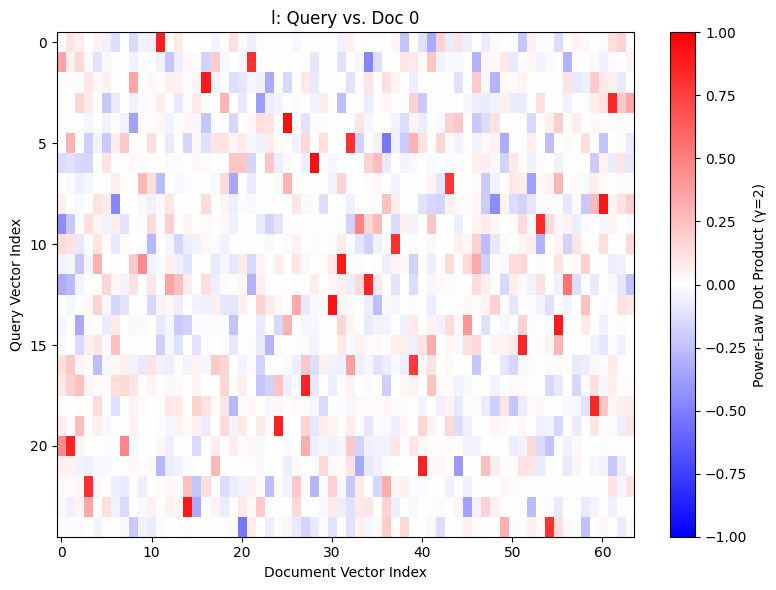

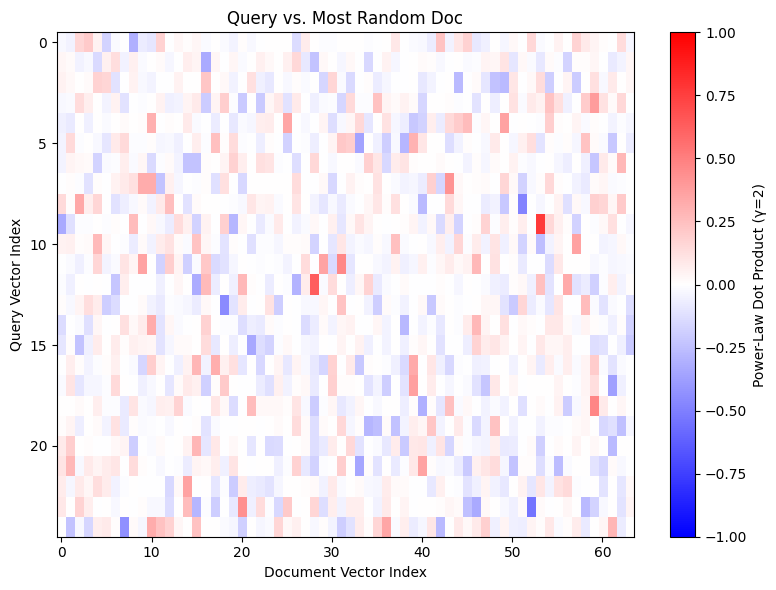

k=4 completed in 2.5250 seconds.
k=8 completed in 1.6398 seconds.
k=16 completed in 1.7950 seconds.
k=32 completed in 1.9001 seconds.
k=64 completed in 1.8156 seconds.

Finished experiment with varying k in 9.6765 seconds.


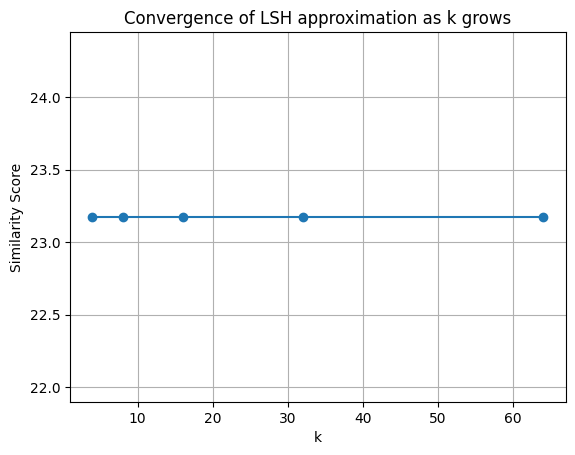

Best k = 4 → doc #0


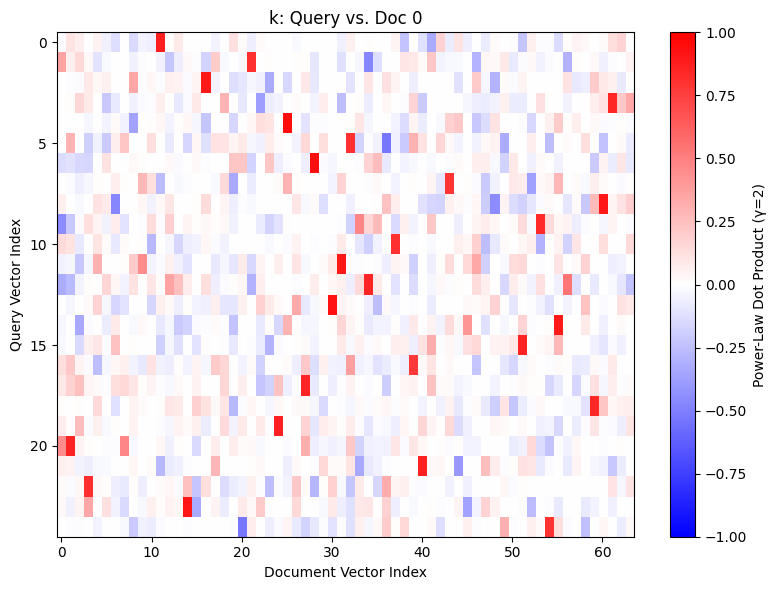

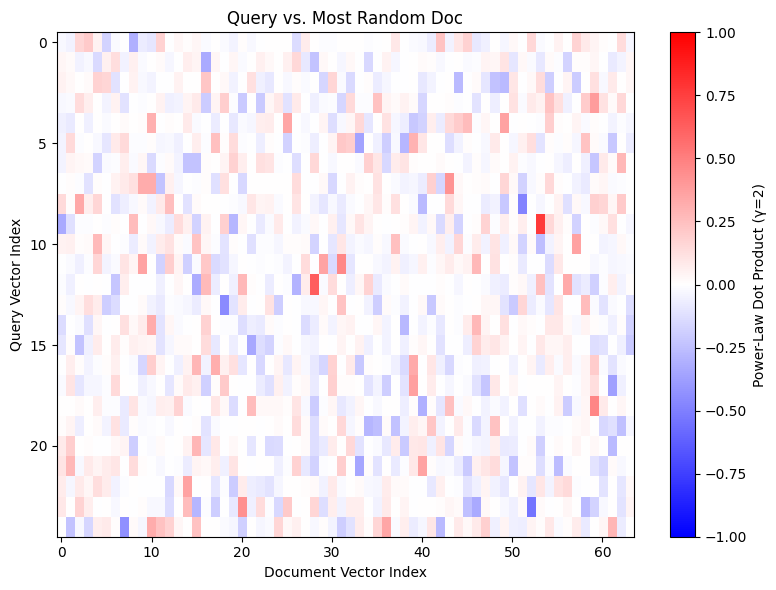

km=16 completed in 0.9768 seconds.
km=32 completed in 0.9338 seconds.
km=64 completed in 1.8467 seconds.
km=128 completed in 3.1859 seconds.
km=256 completed in 6.7356 seconds.

Finished experiment with varying km in 13.6795 seconds.


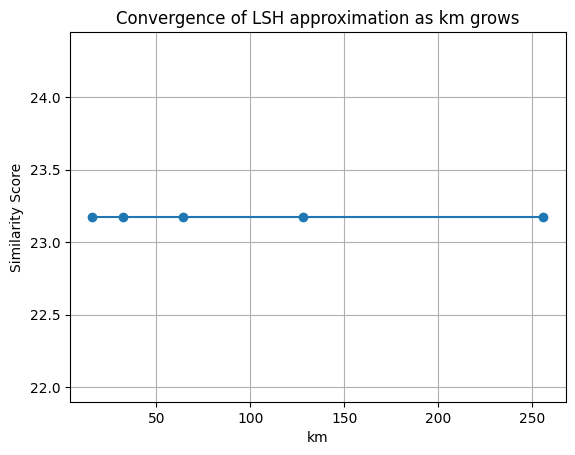

Best km = 16 → doc #0


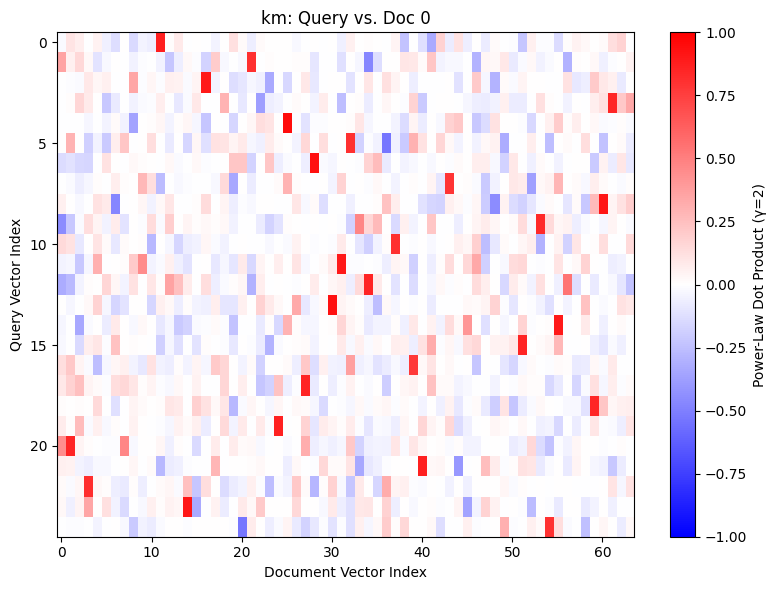

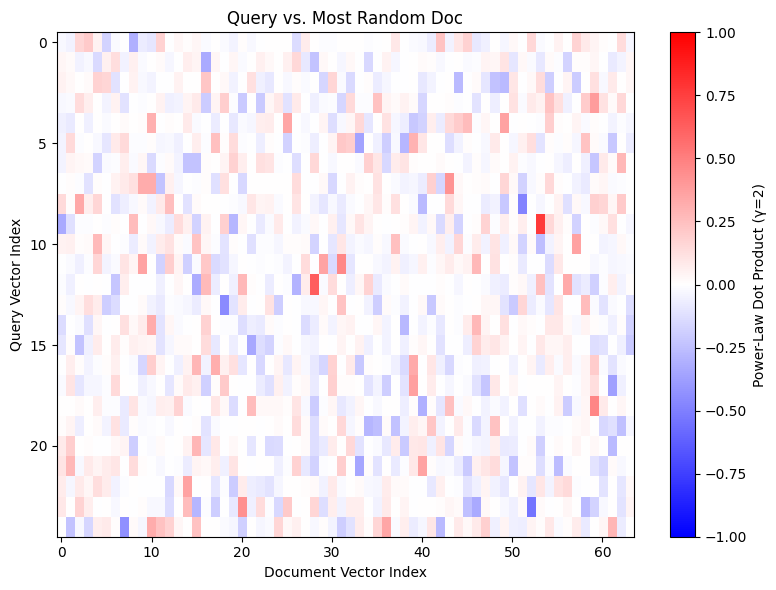

a=1 completed in 1.1854 seconds.
a=4 completed in 2.8326 seconds.
a=8 completed in 2.0829 seconds.
a=16 completed in 1.8713 seconds.
a=32 completed in 1.5580 seconds.

Finished experiment with varying a in 9.5309 seconds.


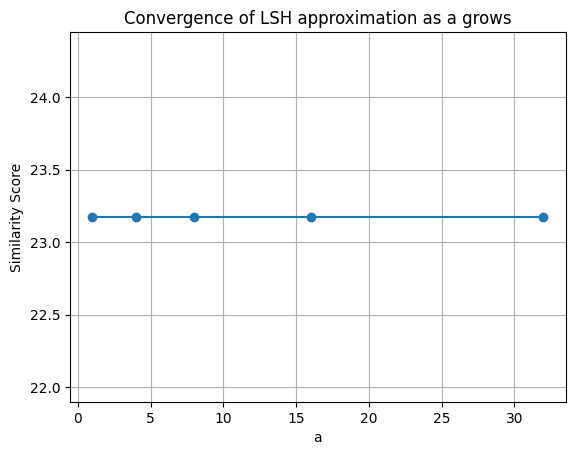

Best a = 1 → doc #0


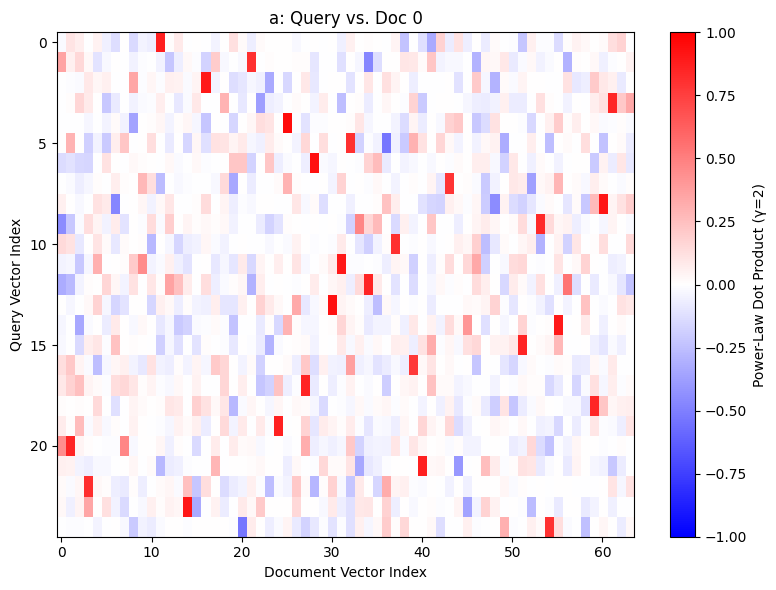

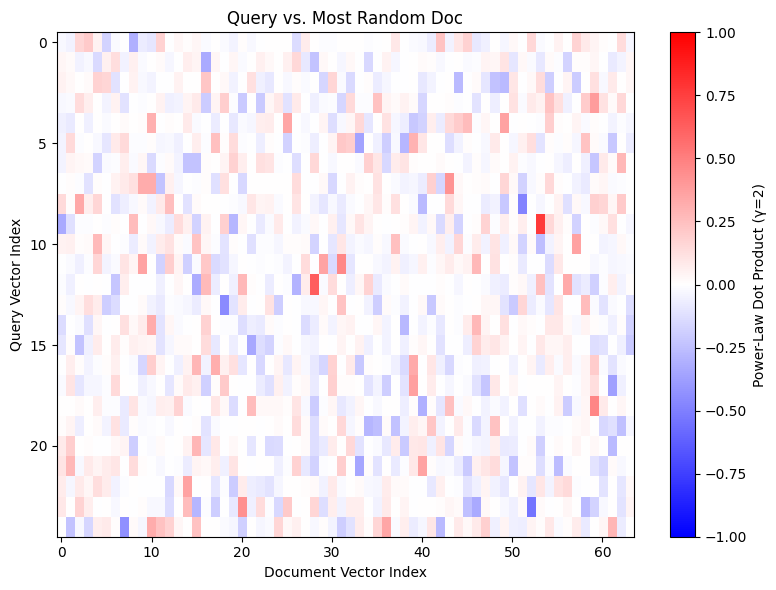

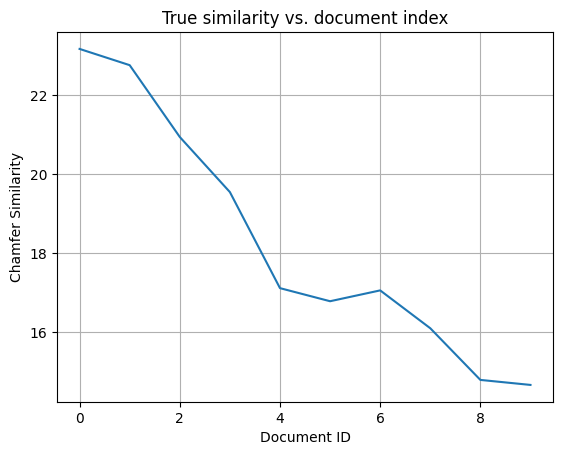

In [22]:
# Evaluate single-doc
results = {}
for var, vals in experiments.items():
    sims, docs = experiment(var, vals, defaults, 
                            "simple", 
                            simple_approximate_best, vectors, queries, d)
    results[var] = (sims, docs)
    plot(experiments[var], sims, xlabel=f'{var}')
    
    # Pick the best result and visualize
    best_index = int(np.argmax(sims))
    best_doc_index = docs[best_index]
    print(f"Best {var} = {vals[best_index]} → doc #{best_doc_index}")
    plot_similarity_heatmap(queries, vectors[best_doc_index],
                            title=f"{var}: Query vs. Doc {best_doc_index}")
    plot_similarity_heatmap(queries, vectors[-1], f"Query vs. Most Random Doc")

sims = [chamfer(queries, doc) for doc in vectors]
plt.plot(sims)
plt.xlabel("Document ID")
plt.ylabel("Chamfer Similarity")
plt.title("True similarity vs. document index")
plt.grid(True)
plt.show()


l=1 completed in 0.1506 seconds.
l=4 completed in 1.3174 seconds.
l=8 completed in 1.5358 seconds.
l=16 completed in 3.2377 seconds.
l=32 completed in 6.4303 seconds.

Finished experiment with varying l in 12.6726 seconds.


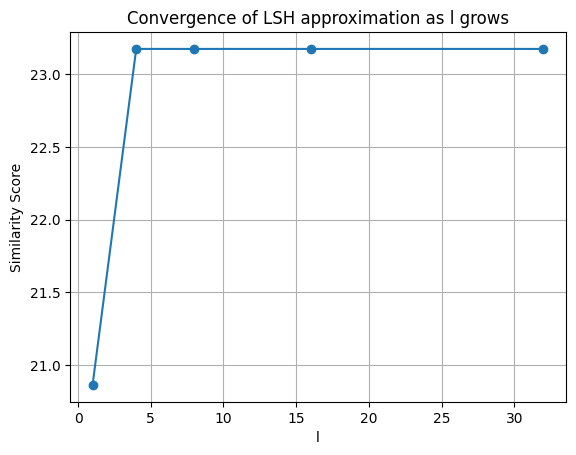

Best l = 4 → doc #0


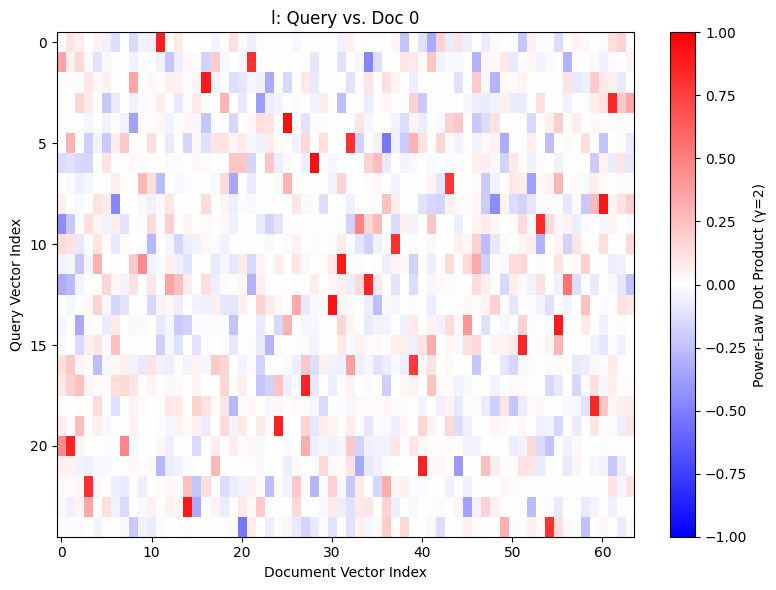

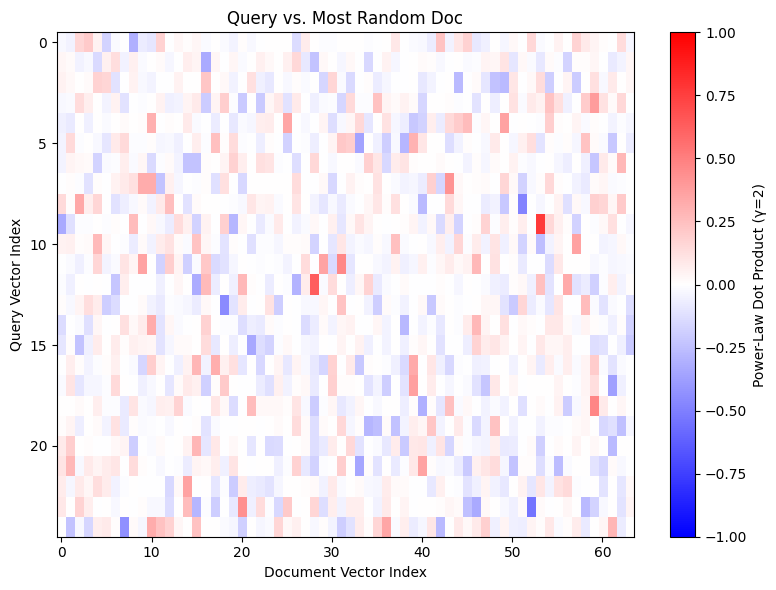

k=4 completed in 1.2831 seconds.
k=8 completed in 3.2094 seconds.
k=16 completed in 2.1980 seconds.
k=32 completed in 2.1109 seconds.
k=64 completed in 2.0391 seconds.

Finished experiment with varying k in 10.8413 seconds.


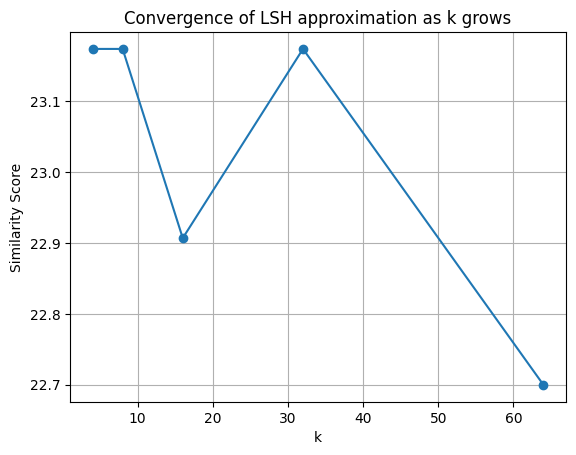

Best k = 4 → doc #0


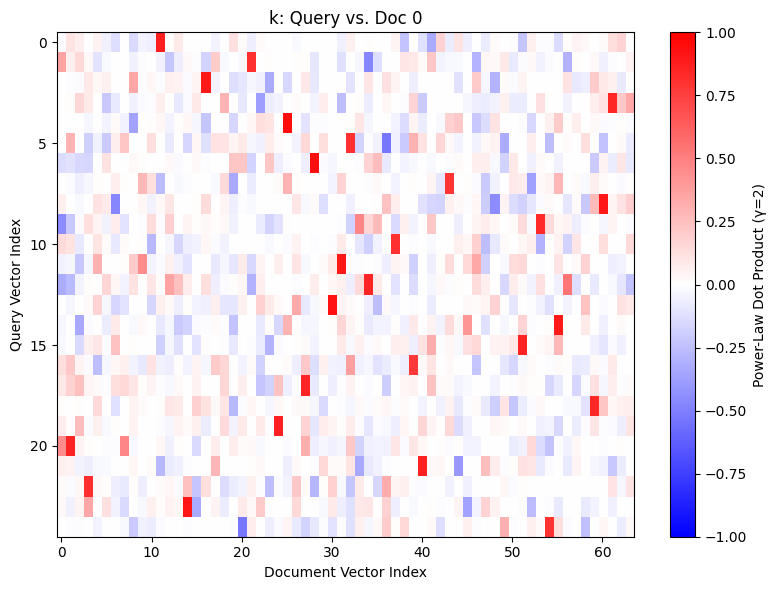

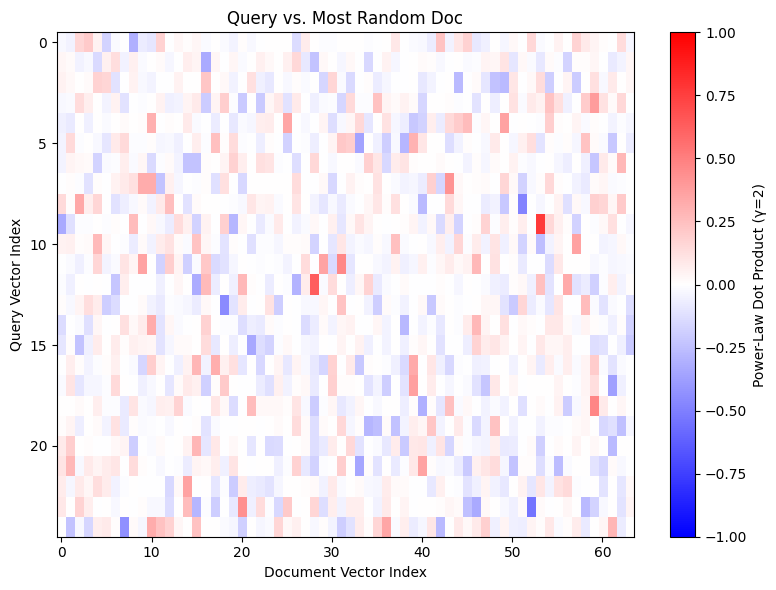

km=16 completed in 0.3052 seconds.
km=32 completed in 1.3891 seconds.
km=64 completed in 2.0835 seconds.
km=128 completed in 4.3134 seconds.
km=256 completed in 7.7279 seconds.

Finished experiment with varying km in 15.8199 seconds.


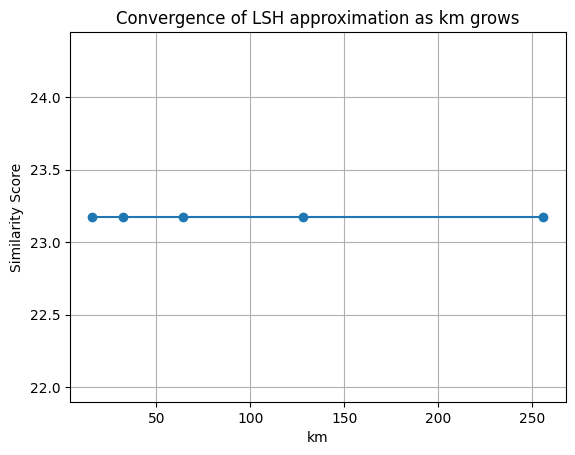

Best km = 16 → doc #0


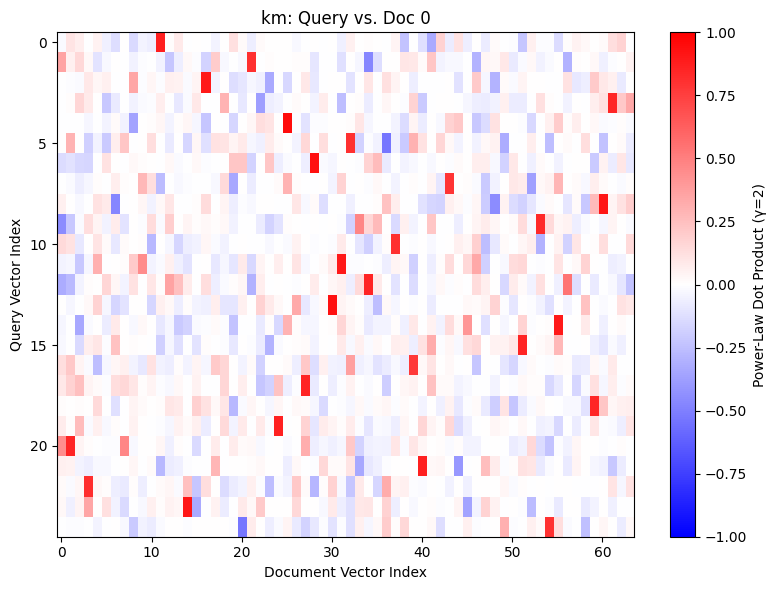

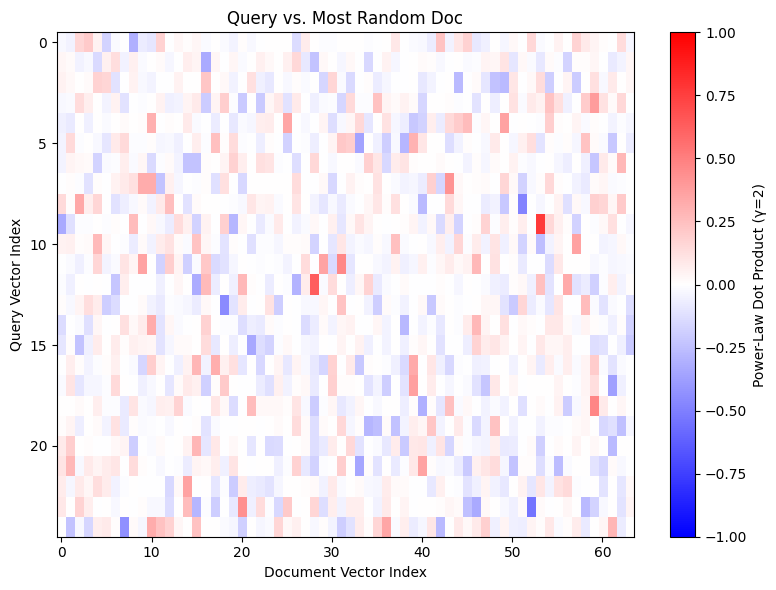

a=1 completed in 3.3580 seconds.
a=4 completed in 1.8514 seconds.
a=8 completed in 2.4484 seconds.
a=16 completed in 2.2173 seconds.
a=32 completed in 2.2390 seconds.

Finished experiment with varying a in 12.1153 seconds.


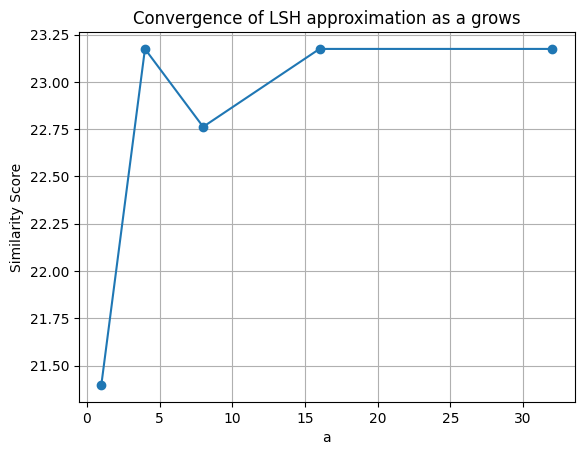

Best a = 4 → doc #0


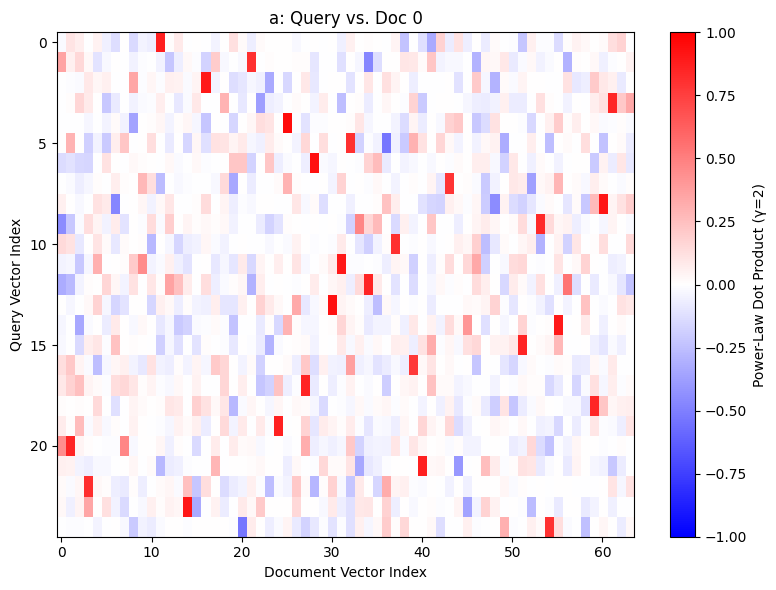

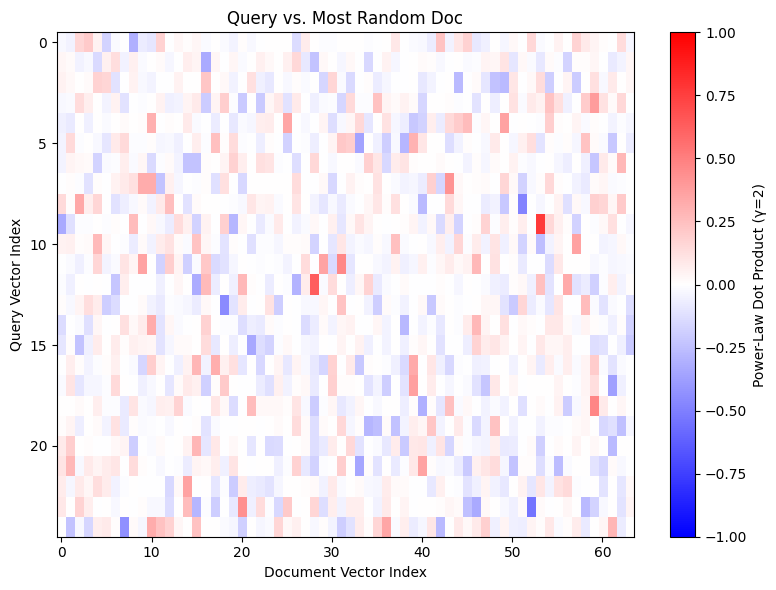

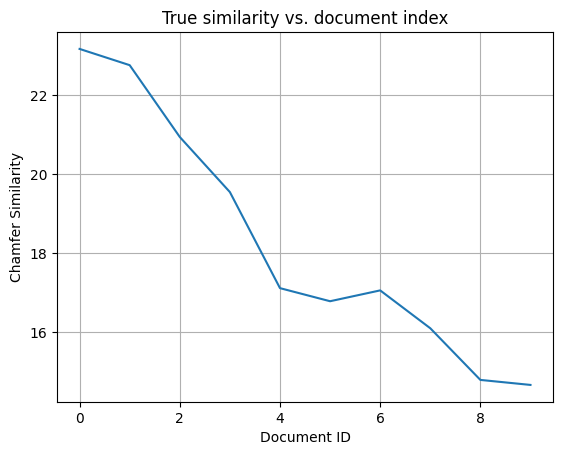

In [24]:

# Evaluate multi-doc
results = {}
for var, vals in experiments.items():
    sims, docs = experiment(var, vals, defaults, 
                            "multidoc", multidoc_approximate_best, vectors, queries, d)
    results[var] = (sims, docs)
    plot(experiments[var], sims, xlabel=f'{var}')
    
    # Pick the best result and visualize
    best_index = int(np.argmax(sims))
    best_doc_index = docs[best_index]
    print(f"Best {var} = {vals[best_index]} → doc #{best_doc_index}")
    plot_similarity_heatmap(queries, vectors[best_doc_index],
                            title=f"{var}: Query vs. Doc {best_doc_index}")
    plot_similarity_heatmap(queries, vectors[-1], f"Query vs. Most Random Doc")

sims = [chamfer(queries, doc) for doc in vectors]
plt.plot(sims)
plt.xlabel("Document ID")
plt.ylabel("Chamfer Similarity")
plt.title("True similarity vs. document index")
plt.grid(True)
plt.show()
